<a href="https://colab.research.google.com/github/Krankile/npmf/blob/main/notebooks/fundamental_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [84]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
%%capture
!git clone https://github.com/Krankile/npmf.git

In [86]:
%%capture
!cd npmf && git pull

In [4]:
%%capture
!pip install wandb

In [5]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


##General setup

In [87]:
import os
from collections import defaultdict
from collections import Counter
from datetime import datetime
from operator import itemgetter

import numpy as np
from numpy.ma.core import outerproduct
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

import wandb as wb

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from npmf.utils.colors import main, main2, main3
from npmf.utils.eikon import column_mapping
from npmf.utils.wandb import get_dataset, put_dataset

In [7]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[main, main2, main3, "black"])
mpl.rcParams['figure.figsize'] = (6, 4)  # (6, 4) is default and used in the paper

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [9]:
np.random.seed(420)

# Process fundamental data

## Start by defining $\mathcal{D}^{fun}_T$

In [146]:
fundamental_oil_df = get_dataset("oil-fundamental-data:v1", "master-test").rename(columns=column_mapping) #Need v1 as asking for price book seems to have removed announce dates in oil (and we no longer use price_book)
fundamental_banking_df = get_dataset("banking-fundamental-data:latest", "master-test").rename(columns=column_mapping)

Unfortunately there is almost no price book enteries where there are annoucement dates, therefore we are not comfortable using the data as we would have to assume some time of announcment (with large lag) which could nonetheless be inducing time leakage. As such, we remove price_book column   

In [147]:
fundamental_banking_df = fundamental_banking_df.drop(columns="price_book")

In [148]:
fundamental_banking_df

,ticker,date,period_end_date,announce_date,revenue,gross_profit,ebitda,ebit,net_income,total_assets,total_current_assets,total_liabilites,total_current_liabilities,long_term_debt_p_assets,short_term_debt_p_assets,fcf
0,KAER.VI,None,None,,<NA>,<NA>,<NA>,9776460.847967,8634951.329748,3326024663.38403,<NA>,3073945705.69524,<NA>,7.21831,<NA>,<NA>
1,KAER.VI,None,None,,<NA>,<NA>,<NA>,12350159.136203,10404342.223101,3714558235.91818,<NA>,3425426098.33725,<NA>,7.15891,<NA>,<NA>
2,KAER.VI,None,None,,<NA>,<NA>,<NA>,11111001.499487,9594268.024626,3676885210.32278,<NA>,3387886709.8098,<NA>,7.4641,<NA>,<NA>
3,KAER.VI,None,None,2003-02-26,<NA>,<NA>,<NA>,-12137624.115708,-16290205.586601,3919973969.81338,<NA>,3587682893.54913,<NA>,7.33097,<NA>,<NA>
4,KAER.VI,None,None,,<NA>,<NA>,<NA>,12576583.266897,11067308.483792,4073344108.68544,<NA>,3740998394.61815,<NA>,7.17495,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143580,CRDI.MI,None,None,,<NA>,<NA>,<NA>,<NA>,-424591248.86539,1137586712261.850098,<NA>,1064379579872.97998,<NA>,12.14142,<NA>,<NA>
143581,CRDI.MI,None,None,2021-05-06,<NA>,<NA>,<NA>,<NA>,1076155261.38888,1104971500949.969971,<NA>,1033313395726.319946,<NA>,11.80282,<NA>,<NA>
143582,CRDI.MI,None,None,,<NA>,<NA>,<NA>,<NA>,1251627499.51837,1126274109990.159912,<NA>,1053007006271.26001,<NA>,11.13588,<NA>,<NA>
143583,CRDI.MI,None,None,2021-10-28,<NA>,<NA>,<NA>,<NA>,1258917567.36172,1098559318108.119995,<NA>,1026005234631.949951,<NA>,11.62997,<NA>,<NA>


In [149]:
better_column_order  = ["ticker", "date", "period_end_date", "announce_date", "revenue", "gross_profit", "ebitda", "ebit", "net_income", "fcf", "total_assets", "total_current_assets", "total_liabilites"	, "total_current_liabilities", "long_term_debt_p_assets", "short_term_debt_p_assets"]

fundamental_oil_df = fundamental_oil_df.loc[:, better_column_order]
fundamental_banking_df = fundamental_banking_df.loc[:, better_column_order]

In [150]:
fundamental_oil_df = fundamental_oil_df[(fundamental_oil_df.announce_date != "") & (~fundamental_oil_df.announce_date.isnull())]
fundamental_banking_df = fundamental_banking_df[(fundamental_banking_df.announce_date != "") & (~fundamental_banking_df.announce_date.isnull())]

In [151]:
fundamental_df = pd.concat([fundamental_oil_df, fundamental_banking_df], axis=0)

In [169]:
oil_values = fundamental_oil_df.count(axis=0, numeric_only=True).sum()
banking_values = fundamental_banking_df.count(axis=0, numeric_only=True).sum()
oil_unique_companies = fundamental_oil_df.ticker.unique()
banking_unique_companies = fundamental_banking_df.ticker.unique()
unique_companies = list(set(oil_unique_companies) | set(banking_unique_companies))
print(f"unique companies: {len(unique_companies)}")
total_values = oil_values + banking_values
print(f"total values: {total_values}")

unique companies: 3593
total values: 1618963


$\mathcal{D}^{fun}_T$ = 1,618,963.  How ever, having this many quarterly datapoints surely contains some error — lets delve deeper! 

## Now we explore and clean the data

In [153]:
fundamental_df

,ticker,date,period_end_date,announce_date,revenue,gross_profit,ebitda,ebit,net_income,fcf,total_assets,total_current_assets,total_liabilites,total_current_liabilities,long_term_debt_p_assets,short_term_debt_p_assets
1,OMVV.VI,2000-06-30T00:00:00Z,2000-06-30,2000-10-23,1591395023.28372,230190745.555143,181045434.200878,105530002.190288,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,OMVV.VI,2000-12-31T00:00:00Z,2000-12-31,2001-04-30,1938098647.94837,372273990.672257,228378009.139304,132398360.578508,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,OMVV.VI,2001-03-31T00:00:00Z,2001-03-31,2001-11-15,1675754784.0278,270127135.374168,246253937.336036,174937923.894256,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
5,OMVV.VI,2001-06-30T00:00:00Z,2001-06-30,2001-11-15,1704178457.61632,261593371.574251,199438283.407691,139758657.318887,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
6,OMVV.VI,2001-09-30T00:00:00Z,2001-09-30,2001-11-08,1692966706.46458,247021992.14371,223213423.136865,133206040.77615,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143575,CRDI.MI,None,None,2019-11-07,<NA>,<NA>,<NA>,<NA>,1341476826.9806,<NA>,940549258936.355957,<NA>,874669790758.5,<NA>,12.85861,<NA>
143577,CRDI.MI,None,None,2020-05-06,<NA>,<NA>,<NA>,<NA>,-2924383456.42154,<NA>,962559832359.10498,<NA>,895007168854.08606,<NA>,12.17882,<NA>
143579,CRDI.MI,None,None,2020-11-05,<NA>,<NA>,<NA>,<NA>,800597479.412101,<NA>,1058546502771.300049,<NA>,986963756313.057007,<NA>,12.68065,<NA>
143581,CRDI.MI,None,None,2021-05-06,<NA>,<NA>,<NA>,<NA>,1076155261.38888,<NA>,1104971500949.969971,<NA>,1033313395726.319946,<NA>,11.80282,<NA>


In [154]:
#create margin coloumns 
for col in fundamental_df.columns[5:10]:

    fundamental_df[f"{col}_p_revenue"] = fundamental_df[col] / fundamental_df.revenue
fundamental_df = fundamental_df.replace([np.inf, -np.inf], np.nan)

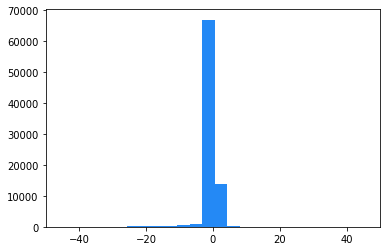

In [156]:
plt.xlim(-50,50)
plt.hist(fundamental_df["ebitda_p_revenue"].dropna().values.flatten(), bins=30_000);

 ## Remove companies with weird data

Loop to explore where data is lost

In [157]:
lost_companies_to_values_left = {}
ebitda_restriction_to_values_left = {}

for num in tqdm(np.linspace(100,0,1000)):
    weird_positive_df = fundamental_df[fundamental_df.ebitda_p_revenue >= num]
    weird_negative_df = fundamental_df[fundamental_df.ebitda_p_revenue <= -num -0.5]
    
        
    lost_companies = set(weird_positive_df["ticker"].unique()) | set(weird_positive_df["ticker"].unique())

    lost_companies_count = len(lost_companies)

    values_left = total_values - fundamental_df[fundamental_df["ticker"].isin(list(lost_companies))].count(axis=0, numeric_only=True).sum()

    lost_companies_to_values_left[lost_companies_count] =  values_left
    ebitda_restriction_to_values_left[num] = values_left



100%|██████████| 1000/1000 [00:48<00:00, 20.48it/s]


 Visualise data

In [170]:

xs = []
ys = []
for key in lost_companies_to_values_left:
    xs += [key]
    ys += [lost_companies_to_values_left[key]]

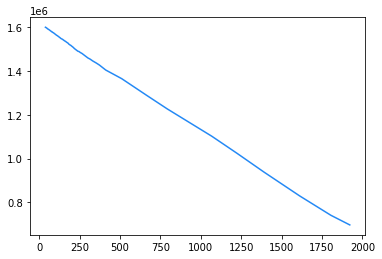

In [171]:
plt.plot(xs,ys);

In [172]:
xs1 = []
ys1 = []
for key in ebitda_restriction_to_values_left:
    xs1 += [key]
    ys1 += [ebitda_restriction_to_values_left[key]]

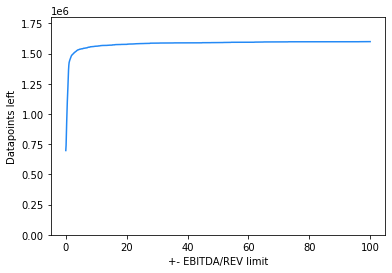

In [174]:
plt.ylim(-1,1_800_000)
plt.ylabel("Datapoints left")
plt.xlabel("+- EBITDA/REV limit")
plt.plot(xs1,ys1);

Select a specific EBITDAp space and all companies with EBITDAp in that space

In [178]:
weird_positive_df = fundamental_df[fundamental_df.ebitda_p_revenue >= 1]
weird_negative_df = fundamental_df[fundamental_df.ebitda_p_revenue <= -5]

    
lost_companies = set(weird_positive_df["ticker"].unique()) | set(weird_positive_df["ticker"].unique())

lost_companies_count = len(lost_companies)

values_left = total_values - fundamental_df[fundamental_df["ticker"].isin(list(lost_companies))].count(axis=0, numeric_only=True).sum()



print(f"unique companies left: {len(unique_companies) - lost_companies_count}")
print(f"values left: {values_left}")

unique companies left: 3179
values left: 1403161


In [182]:
#get only valid companies (non bogus ebitdas)
cleaned_df = fundamental_df[fundamental_df["ticker"].isin(set(fundamental_df["ticker"].unique()) -  lost_companies)]

# Add data with forward fill



In [183]:
from matplotlib import axis
forward_filled_df = pd.DataFrame(columns=cleaned_df.columns) 

for ric in tqdm(cleaned_df["ticker"].unique()):
    forward_filled_df = pd.concat( [forward_filled_df, cleaned_df[cleaned_df["ticker"] == ric].ffill(axis = 0)], axis=0)

100%|██████████| 3179/3179 [02:49<00:00, 18.78it/s]


In [184]:
forward_filled_df

,ticker,date,period_end_date,announce_date,revenue,gross_profit,ebitda,ebit,net_income,fcf,...,total_current_assets,total_liabilites,total_current_liabilities,long_term_debt_p_assets,short_term_debt_p_assets,gross_profit_p_revenue,ebitda_p_revenue,ebit_p_revenue,net_income_p_revenue,fcf_p_revenue
1,OMVV.VI,2000-06-30T00:00:00Z,2000-06-30,2000-10-23,1591395023.28372,230190745.555143,181045434.200878,105530002.190288,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,0.144647,0.113765,0.066313,NaN,NaN
3,OMVV.VI,2000-12-31T00:00:00Z,2000-12-31,2001-04-30,1938098647.94837,372273990.672257,228378009.139304,132398360.578508,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,0.192082,0.117836,0.068314,NaN,NaN
4,OMVV.VI,2001-03-31T00:00:00Z,2001-03-31,2001-11-15,1675754784.0278,270127135.374168,246253937.336036,174937923.894256,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,0.161197,0.146951,0.104394,NaN,NaN
5,OMVV.VI,2001-06-30T00:00:00Z,2001-06-30,2001-11-15,1704178457.61632,261593371.574251,199438283.407691,139758657.318887,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,0.153501,0.117029,0.082009,NaN,NaN
6,OMVV.VI,2001-09-30T00:00:00Z,2001-09-30,2001-11-08,1692966706.46458,247021992.14371,223213423.136865,133206040.77615,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,0.145911,0.131847,0.078682,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127032,QNBFL.IS,2020-12-31T00:00:00Z,2020-12-31,2021-01-27,22561625.40366,23938961.038961,19901776.103337,19684876.210979,4358783.68047,-55370641.251227,...,976299863.343528,914465419.806243,0.0,79.43442,16.24148,1.0,0.882107,0.872494,0.193195,-2.454196
127033,QNBFL.IS,2021-03-31T00:00:00Z,2021-03-31,2021-04-27,22040660.367059,23938961.038961,19429517.582697,19229733.499921,5300725.873309,2229011.378327,...,976299863.343528,883333373.76727,0.0,78.55885,16.24148,1.0,0.881531,0.872466,0.240498,0.101132
127034,QNBFL.IS,2021-06-30T00:00:00Z,2021-06-30,2021-07-28,22471477.647437,23938961.038961,19866148.879212,19660604.110895,5087399.819672,-19495675.682312,...,976299863.343528,890567919.390604,0.0,46.78473,23.34352,1.0,0.884061,0.874914,0.226394,-0.867574
127035,QNBFL.IS,2021-09-30T00:00:00Z,2021-09-30,2021-10-26,23414395.354595,23938961.038961,20764106.142108,20558956.584367,5429177.975195,-11886504.625681,...,976299863.343528,956602934.887804,0.0,57.43615,17.6007,1.0,0.886809,0.878048,0.231874,-0.507658


In [185]:
filename = 'fundamental-data-clean.feather'

forward_filled_df.reset_index().to_feather(filename)

In [192]:
upload = True
if upload:
    put_dataset(forward_filled_df.reset_index(), filename=filename, project="master-test")